# Building LRG Templates

The goal of this notebook is to use observations of a large number of luminous red galaxies (LRGs) with DECaLS/DR3 *grzW1W2* photometry and ancillary spectroscopic redshifts to generate a set of spectroscopic templates suitable for spectroscopic simulations, targeting investigations, and other DESI-related projects.

The parent sample consists of 2,511,248 LRGs selected from the official DECaLS/DR3.1 target catalog `targets-dr3.1-0.14.0.fits` using the selection criterion
```python
DESI_TARGET & desi_mask.LRG != 0
```

Subsequently, Rongpu Zhou (Pittsburgh) assembled spectroscopic redshifts for the sample from SDSS/Main, SDSS/BOSS, AGES, DEEP2, and VIPERS, supplemented with COSMOS medium-band photometric redshifts, yielding precise redshifts for 62,177 objects (2.4% of the parent sample).  Using these data, Zhou used a random forest technique (described elsewhere) to compute photometric redshifts for the complete sample, producing the catalog `dr3.1-0.14.0-lrg-rf-photoz-0.2.fits`, which we use as input into the generation of the spectral templates.

Specifically, we adopt the following procedure:
  1.  We focus exclusively on the subset of 62,177 LRGs with spectroscopic redshifts since we find that the training sample is fairly representative of the full sample in the four-dimensional space of *g-r*, *r-z*, *z*-band magnitude, and redshift.  (Future versions of these templates may utilize the random forest photometric redshifts.)
  2. We use the Bayesian spectral energy distribution (SED) modeling code [iSEDfit](http://www.sos.siena.edu/~jmoustakas/isedfit) and the CKC14z simple stellar population models of Conroy et al. to model the observed SEDs of the parent sample of galaxies.  The outputs of this code are the best-fitting (maximum likelihood) spectroscopic template and the marginalized posterior distributions on a large number of quantities of interest (`legacysurvey_lrg_ckc14z_kroupa01_charlot_sfhgrid01.fits`).  In addition, we compute K-corrected absolute magnitudes in the DECaLS *g*-, *r*-, and *z*-band bandpasses (`legacysurvey_lrg_ckc14z_kroupa01_charlot_sfhgrid01_kcorr.z0.0.fits`).
  3. We select a quasi-representative subset of these models for use as basis templates using a simple kd-tree built from the rest-frame 

John Moustakas
Siena College
2017 September 21

## Preliminaries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.table import Table
from scipy.spatial import cKDTree as KDTree
from corner import corner

In [12]:
plt.style.use('seaborn-talk')
%matplotlib inline

## Read the iSEDfit and absolute magnitude catalogs

Need to move these catalogs to a standard location!

In [3]:
cat = Table.read('legacysurvey_lrg_ckc14z_kroupa01_charlot_sfhgrid01.fits.gz')
cat[:2]

ISEDFIT_ID,RA,DEC,Z,MAGGIES [5],IVARMAGGIES [5],BESTMAGGIES [5],CHUNKINDX,MODELINDX,DELAYED,BURSTTYPE,CHI2,TOTALMASS,TOTALMASS_ERR,MSTAR,AGE,SFRAGE,TAU,ZMETAL,AV,MU,OIIIHB,NLYC,SFR,SFR100,B100,B1000,EWOII,EWOIIIHB,EWNIIHA,NBURST,TRUNCTAU,TBURST,DTBURST,FBURST,MSTAR_50,AGE_50,SFRAGE_50,TAU_50,ZMETAL_50,AV_50,MU_50,OIIIHB_50,SFR_50,SFR100_50,B100_50,B1000_50,EWOII_50,EWOIIIHB_50,EWNIIHA_50,MSTAR_AVG,AGE_AVG,SFRAGE_AVG,TAU_AVG,ZMETAL_AVG,AV_AVG,MU_AVG,OIIIHB_AVG,SFR_AVG,SFR100_AVG,B100_AVG,B1000_AVG,EWOII_AVG,EWOIIIHB_AVG,EWNIIHA_AVG,MSTAR_ERR,AGE_ERR,SFRAGE_ERR,TAU_ERR,ZMETAL_ERR,AV_ERR,MU_ERR,OIIIHB_ERR,SFR_ERR,SFR100_ERR,B100_ERR,B1000_ERR,EWOII_ERR,EWOIIIHB_ERR,EWNIIHA_ERR
int32,float64,float64,float32,float32,float32,float32,int16,int16,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
0,7.10186257679,-3.84164260827,0.493305,1.7658e-09 .. 2.19342e-08,2.10202e+20 .. 1.63934e+17,1.95907e-09 .. 2.72933e-08,0,3005,1,1,3.4034,3.79652e+11,2.49584e+09,11.3572,8.43379,8.25055,0.0916157,0.00775165,0.208418,0.506265,-1.0,52.1077,-3.42061,-3.42061,-15.0,-15.0,-1.0,-1.0,-1.0,0,-1.0,-1.0,-1.0,-1.0,11.3304,7.99743,6.93651,0.124043,0.00873057,0.314216,0.357754,-1.0,-3.42019,-3.42019,-15.0,-13.4455,-1.0,-1.0,-1.0,11.319,7.49219,6.91142,0.290627,0.0089476,0.36689,0.349315,-1.0,-2.85242,-3.17479,-10.7666,-10.4481,-1.0,-1.0,-1.0,0.059242,0.856211,0.86443,0.199598,0.00219014,0.323897,0.0918706,0.0,0.735066,0.493306,2.93409,3.00125,0.0,0.0,0.0
1,7.23270630501,-3.73900323383,0.596124,1.21947e-09 .. 3.73271e-08,3.41204e+20 .. 1.61952e+17,1.38542e-09 .. 4.38815e-08,0,1746,1,1,4.81293,7.38799e+11,3.82096e+09,11.6527,6.85219,6.73449,0.0588457,0.0144248,0.174484,0.521158,-1.0,52.1897,-3.13147,-3.13147,-15.0,-15.0,-1.0,-1.0,-1.0,0,-1.0,-1.0,-1.0,-1.0,11.6497,6.91977,6.72835,0.100916,0.0144248,0.406731,0.254227,-1.0,-3.12706,-3.13482,-15.0,-15.0,-1.0,-1.0,-1.0,11.6523,7.06551,6.69376,0.185881,0.0141004,0.372666,0.320061,-1.0,-2.96507,-3.12227,-12.9086,-12.6098,-1.0,-1.0,-1.0,0.0230553,0.353224,0.365486,0.113796,0.00143068,0.188852,0.0777556,0.0,0.249084,0.024488,2.43004,2.54153,0.0,0.0,0.0


In [4]:
kcorr = Table.read('legacysurvey_lrg_ckc14z_kroupa01_charlot_sfhgrid01_kcorr.z0.0.fits.gz')
kcorr[:2]

ISEDFIT_ID,Z,MAGGIES [5],IVARMAGGIES [5],CHI2,FLAM_1500,CFLUX_3727,KCORRECT [3],ABSMAG [3],IVARABSMAG [3],SYNTH_ABSMAG [3],ABSMAG_FILTERLIST [3]
int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str11
0,0.493305,1.7658e-09 .. 2.19342e-08,2.10202e+20 .. 1.63934e+17,3.4034,8.62409e-19,1.93438e-17,0.0124708 .. 0.0714089,-22.1503 .. -23.2998,8778.52 .. 9104.59,-22.1392 .. -23.3014,decam_g.par .. decam_z.par
1,0.596124,1.21947e-09 .. 3.73271e-08,3.41204e+20 .. 1.61952e+17,4.81293,6.44898e-19,1.93495e-17,0.415429 .. 0.191121,-22.7973 .. -24.0572,9283.86 .. 18576.3,-22.7938 .. -24.0487,decam_g.par .. decam_z.par


## Select a semi-uniform sampling of galaxies

In [5]:
zobj, Mg, Mr, Mz = (kcorr['Z'], kcorr['ABSMAG'][:, 0], kcorr['ABSMAG'][:, 1], kcorr['ABSMAG'][:, 2] )

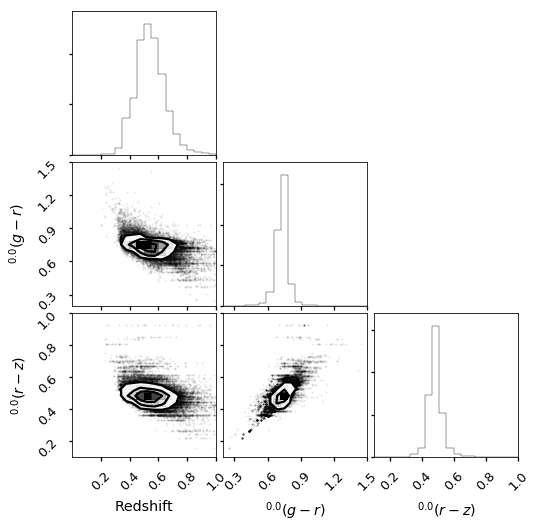

In [13]:
fig = corner(np.vstack((zobj, Mg-Mr, Mr-Mz)).T, 
             labels=('Redshift', r'$^{0.0}(g - r)$', r'$^{0.0}(r - z)$'),
             range=( (0, 1), (0.2, 1.5), (0.1, 1.0) ))

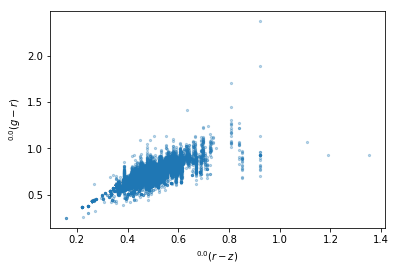

In [17]:
fig, ax = plt.subplots()
ax.scatter(Mr-Mz, Mg-Mr, alpha=0.3, s=5)
ax.set_xlabel(r'$^{0.0}(r - z)$')
ax.set_ylabel(r'$^{0.0}(g - r)$')

In [29]:
tree = KDTree( np.vstack((zobj, Mg-Mr, Mr-Mz)).T )

In [ ]:
def get_close_templates(zobs, zobs_ages, rmabs, rmabs_ages, gr, gr_ages, 
                       dzmin=0.05, drmabsmin=0.1, dgrmin=0.05):

    dz = zobs[:, None] - zobs_ages[None, :]
    drmabs = rmabs[:, None] - rmabs_ages[None, :]
    dgr = gr[:, None] - gr_ages[None, :]

    close = ((np.abs(dz) < dzmin) * 
             (np.abs(drmabs) < drmabsmin) * 
             (np.abs(dgr) < dgrmin)) * 1

    noneclose = np.where(np.sum(close, axis=1) == 0)[0]
    if len(noneclose) > 0:
        dist = np.sqrt(dz**2 + drmabs**2 + dgr**2)
        nearest = np.argmin(dist[noneclose, :], axis=1)
        close[noneclose, nearest] = 1
    #print(np.where(np.sum(close, axis=1) == 0)) # check we did it right
    
    return close

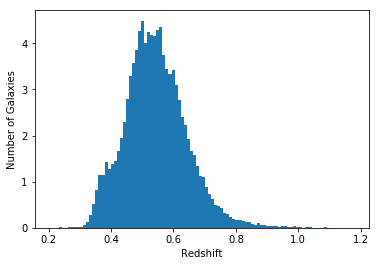

In [22]:
fig, ax = plt.subplots()
_ = ax.hist(kcorr['Z'], bins=100, normed=True)
ax.set_xlabel('Redshift')
ax.set_ylabel('Number of Galaxies')